### 1) Setup

In [65]:
# --- Setup ---
from pathlib import Path, PurePath
import os

USE_VISION = True

ROOT    = Path.cwd().resolve()                  # uruchom z MetaLogic/notebooks
IMG_PATH= ROOT.parent / "inputs" / "0043.jpg"   # podmień
OUT_DIR = ROOT.parent / "outputs" / "single"; OUT_DIR.mkdir(parents=True, exist_ok=True)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.home() / "secrets" / "vision-key.json")

assert IMG_PATH.exists(), f"Brak pliku: {IMG_PATH}"
if USE_VISION:
    cred = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS","")
    assert cred and Path(cred).exists(), f"Brak klucza: {cred}"

print("ready:", IMG_PATH.name)

ready: 0043.jpg


### 2) Google Vision: labels, objects, texts, logos

In [66]:
label_tags, object_tags, boxes_vis, texts, logo_tags = [], [], [], [], []
if USE_VISION:
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    with open(IMG_PATH, "rb") as f:
        gimg = vision.Image(content=f.read())

    LABEL_THR, OBJ_THR, LOGO_THR = 0.60, 0.60, 0.50

    labels = client.label_detection(image=gimg).label_annotations
    label_tags = [l.description.lower() for l in labels if (l.score or 0)>=LABEL_THR]

    objects = client.object_localization(image=gimg).localized_object_annotations
    object_tags = [o.name.lower() for o in objects if (o.score or 0)>=OBJ_THR]
    boxes_vis = [
        (o.name.lower(), [(v.x, v.y) for v in o.bounding_poly.normalized_vertices])
        for o in objects if (o.score or 0)>=OBJ_THR
    ]

    text_ann = client.text_detection(image=gimg).text_annotations
    if text_ann:
        for t in text_ann[1:]:
            s = t.description.strip().lower()
            if len(s)>=3 and any(ch.isalpha() for ch in s):
                texts.append(s)

    logos = client.logo_detection(image=gimg).logo_annotations
    logo_tags = [l.description.lower() for l in logos if (l.score or 0)>=LOGO_THR]

print("vision:", len(label_tags), "labels;", len(object_tags), "objects;", len(texts), "texts;", len(logo_tags), "logos")

vision: 4 labels; 2 objects; 6 texts; 1 logos


### 4) Scena z labels (Vision)

In [67]:
scene_top = []
if label_tags:
    scene_map = {
        "public event":  ["crowd","festival","parade","audience","event","concert","performance"],
        "old city street":["street","alley","historic site","town","architecture","building","cobblestone"],
        "factory/workshop":["factory","manufacturing","workshop","industrial","assembly line"],
        "shop/storefront":["storefront","shop","retail","market","supermarket"],
        "park/outdoors": ["park","trees","grass","recreation","outdoor"],
        "transport hub": ["station","platform","bus","tram","railway","terminal"],
    }
    ls = set(label_tags)
    scores = sorted(((k, sum(w in ls for w in v)) for k,v in scene_map.items()), key=lambda x:-x[1])
    scene_top = [s for s in scores if s[1]>0][:3]
scene_top

[('shop/storefront', 1)]

### 5) Summary + miniatura z boxami


LABELS (4):
 • public space
 • retail
 • shade
 • sidewalk

OBJECTS (1):
 • person

TEXTS (6):
 • alkohole
 • lubelska
 • polem
 • sam
 • spożywczy
 • spożywców

LOGOS (1):
 • społem

SCENE: [('shop/storefront', 1)]

preview: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/summary_preview.jpg


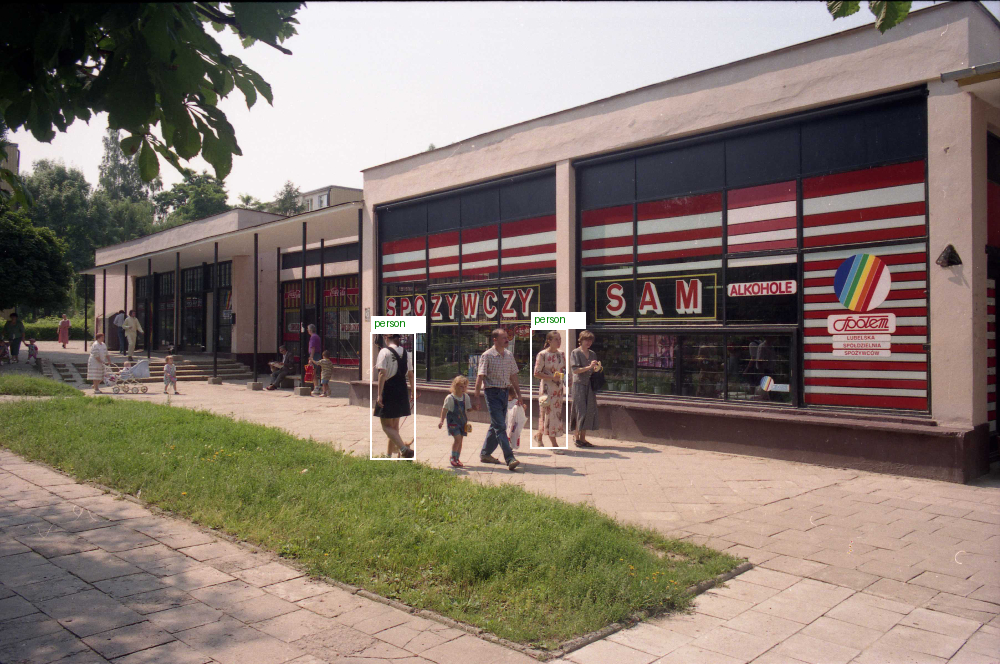

In [68]:
from PIL import Image, ImageDraw
from IPython.display import display

def pretty(title, items, k=60):
    s = sorted(set(items))
    print(f"\n{title} ({len(s)}):")
    for t in s[:k]: print(" •", t)

pretty("LABELS",  label_tags)
pretty("OBJECTS", object_tags)
pretty("TEXTS",      texts)
pretty("LOGOS",   logo_tags)
print("\nSCENE:", scene_top)

img = Image.open(IMG_PATH).convert("RGB")
W,H = img.size
scale = min(1000/W, 1000/H); nw, nh = int(W*scale), int(H*scale)
res = img.resize((nw,nh))
draw = ImageDraw.Draw(res)

for name, verts in boxes_vis:
    pts = [(int(x*nw), int(y*nh)) for x,y in verts]
    if len(pts)>=2:
        draw.line(pts+[pts[0]], width=2)
        x0,y0=pts[0]
        draw.rectangle([x0,y0-16,x0+8*len(name)+6,y0], fill=(255,255,255))
        draw.text((x0+3,y0-15), name, fill=(0,128,0))

for verts in ocr_boxes:
    pts = [(int(x*nw), int(y*nh)) for x,y in verts]
    draw.line(pts+[pts[0]], width=1)

out_img = OUT_DIR/"summary_preview.jpg"; res.save(out_img)
print("\npreview:", out_img)
display(res)

### 6) Eksport CSV (Dublin Core)

In [69]:
import pandas as pd
tags = sorted(set(label_tags + object_tags + texts + logo_tags))

rows = [
    ("", "pl", "en", "universal"),
    ("Title","Ulica z szyldami","Street photo with shop signs",""),
    ("Description","Widok ulicy z ludźmi i szyldami.","Street view with people and text signs.",""),
]
for t in tags: rows.append(("Subject","",t,""))

out_csv = OUT_DIR/"import_dlibra.csv"
pd.DataFrame(rows).to_csv(out_csv, index=False, header=False, encoding="utf-8")
print("csv:", out_csv)

csv: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/import_dlibra.csv
